In [1]:
import pandas as pd
import tensorflow as tf
MNIST = tf.keras.datasets.mnist
from matplotlib import pyplot as plt
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = MNIST.load_data()
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


# MNIST image  visualisation with examples

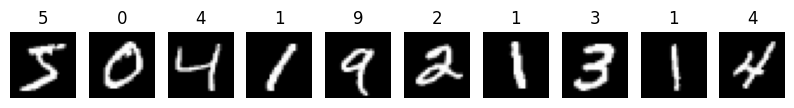

In [3]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

# Gradient Ascent Algorithm

In [4]:
def gradient_ascent(objective_function, gradient_function, initial_theta, eta=0.01, epsilon=1e-6, max_iterations=1000):
    theta = initial_theta
    t = 0
    while t < max_iterations:
        gradient = gradient_function(theta)
        new_theta = theta + eta * gradient
        if np.linalg.norm(new_theta - theta) < epsilon:
            break
        theta = new_theta
        t += 1
    return theta

# Multi-class logistic regression classifer

## Preprocessing

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0 #Normalize the images to bring them in the range of 0 to 1
# Each image is a 28x28 matrix. It is reshaped to a vector of length 784. -1 is taken to maintain the number of rows. 
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
# One-hot encode the labels to convert them into a vector of length 10 to match the output of the neural network.
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)
(x_train, y_train), (x_test, y_test) = MNIST.load_data()
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [6]:
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def predict_proba(theta, x):
    logits = np.dot(x, theta)
    return softmax(logits)

def predict(theta, x):
    proba = predict_proba(theta, x)
    return np.argmax(proba, axis=1)

def compute_accuracy(theta, x, y):
    y_pred = predict(theta, x)
    return np.mean(y_pred == y)

def compute_log_likelihood(theta, x, y):
    logits = np.dot(x, theta)
    log_likelihood = np.sum(logits[np.arange(len(x)), y]) - np.sum(np.log(np.sum(np.exp(logits), axis=1)))
    return log_likelihood

def compute_gradient(theta, x, y, num_classes=10):
    m = len(x)
    logits = np.dot(x, theta) #dot product of x and theta
    proba = softmax(logits)
    
    indicator = np.zeros_like(proba)
    indicator[np.arange(m), y] = 1
    
    gradient = np.dot(x.T, indicator - proba) / m
    return gradient

In [7]:
def gradient_ascent_logistic_regression(x_train, y_train, x_test, y_test, num_classes, eta=0.1, epsilon=1e-6, max_iters=1000):
    # Initialize theta with small random values
    theta = np.random.randn(x_train.shape[1], num_classes)
    costs = []
    train_accs = []
    test_accs = []
    
    for i in range(max_iters):
        # Compute gradient and update theta
        gradient = compute_gradient(theta, x_train, y_train, num_classes)
        theta += eta * gradient
        
        # Compute log-likelihood
        cost = compute_log_likelihood(theta, x_train, y_train)
        costs.append(cost)
        
        # Compute training accuracy
        train_acc = compute_accuracy(theta, x_train, y_train)
        train_accs.append(train_acc)
        
        # Compute testing accuracy
        test_acc = compute_accuracy(theta, x_test, y_test)
        test_accs.append(test_acc)
        
        # Print progress
        if i % 100 == 0:
            print(f"Iteration {i}: Training Accuracy = {train_acc}, Testing Accuracy = {test_acc}, Log-Likelihood = {cost}")
        
        # Check for convergence
        if np.linalg.norm(eta * gradient) < epsilon:
            break
    
    return theta, costs, train_accs, test_accs

# Train the logistic regression classifier
theta, costs, train_accs, test_accs = gradient_ascent_logistic_regression(y_train_one_hot, y_train, y_test_one_hot, y_test, num_classes=10)


Iteration 0: Training Accuracy = 0.19666666666666666, Testing Accuracy = 0.2014, Log-Likelihood = -146970.87519498167
Iteration 100: Training Accuracy = 0.5995, Testing Accuracy = 0.6006, Log-Likelihood = -98950.59456877192
Iteration 200: Training Accuracy = 0.7972833333333333, Testing Accuracy = 0.7973, Log-Likelihood = -64232.69704145362
Iteration 300: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -41686.761377656134
Iteration 400: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -28233.177855801012
Iteration 500: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -20341.788546030293
Iteration 600: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -15532.479111089342
Iteration 700: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -12422.38821485429
Iteration 800: Training Accuracy = 1.0, Testing Accuracy = 1.0, Log-Likelihood = -10290.135591111408
Iteration 900: Training Accuracy = 1.0, Testing Accur

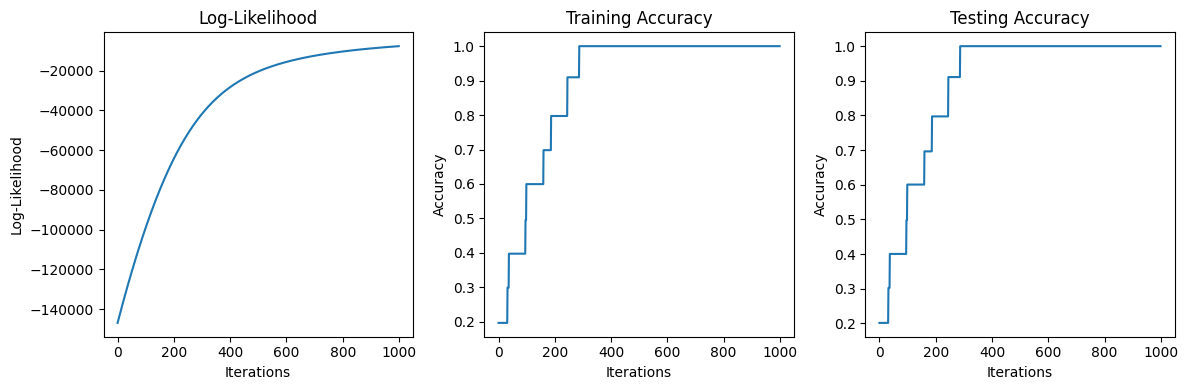

Final Testing Accuracy: 1.0


In [8]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot 1: Cost value (log-likelihood)
plt.subplot(1, 3, 1)
plt.plot(costs)
plt.title('Log-Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')

# Plot 2: Training accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

# Plot 3: Testing accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accs)
plt.title('Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Final testing accuracy
final_test_accuracy = test_accs[-1]
print(f"Final Testing Accuracy: {final_test_accuracy}")